# Titanic

## How can deep learning on irregular domains help to save lifes?

---

*Teo Stocco, Pierre-Alexandre Lee, Yves Lamonato, Charles Thiebaut*, [EPFL](https://epfl.ch).

[Network Tour of Data Science](https://github.com/mdeff/ntds_2017) final project:<br>
This notebook contains a detailed overview through the whole project with all essential parts. As this work required several attempts and exploration, only relevant parts are kept here. You can however access their individual and unguided research notebooks in the `lab` folder.<br>
This project was **not shared** with any other class.

[Binder access](https://mybinder.org/v2/gh/zifeo/Titanic/) | [nbviewer access](https://nbviewer.jupyter.org/github/zifeo/Titanic/blob/master/project.ipynb)

## 0 - Table of content

1. Introduction

2. Data source

3. Preprocessing

4. Graphs

5. Models

6. Evaluation

7. Conclusion

8. References

## 1 - Introduction

Icebergs and ships do not get well along each other. To avoid dramatic events such as the one that happened a century ago, we aim at helping a noble quest: differentiating icebergs and ships based on radar data to see whether any
iceberg is drifting away and might cross the road of a ship.

<br>

|© Statoil/C-CORE - Icebergs and ships examples|
|-|
|![](./img/statoil-ccore.png)|

<br>

This remote sensing measurements can be performed either by planes or by satellites. The second can provide radar information up to 14 time a day as in the case of [Sentinel-1](https://fr.wikipedia.org/wiki/Sentinel-1). The C-Band radar manages to capture data in numerous conditions (e.g. darkness, rain, cloud, fog, etc.) and measures the energy reflected back called backscatter (Torres et al, 2012). Those data can later be analyzed and used to clear out potential collision between icebergs and ships. 

Building on the top of recent advances in the field of signal processing on graphs (Schuman et al., 2013) and deep learning on irregular domains (Bronstein et al., 2017), we investigate the performance of standard machine learning methods and the relevance of graph based convolutional neural networks to perform binary classification in this specific case (layered data). The new method provide a convenient way of getting rotational invariance over the data (Defferrard et al., 2017) and set up a flexible framework for structured pooling. 

As the pooling operations require adequate aggregation by coarsening the graph between layers, we experiment how this framework can be exploited through various processes: Graclus multilevel algorithm and algebraic multigrid techniques. We further extend by comparing on different cases: grid graph, knn graph and wrapped-knn graph. Finally, we show that one can take advantage of graphs to defined structured pooling.

<br>

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sys
import os

In [3]:
# bigger figure
plt.rcParams['figure.figsize'] = 18, 5

In [4]:
# setting seed for reproducability
np.random.seed(0)
torch.manual_seed(0);

In [5]:
# scope to specfic gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## 2 - Data source

The dataset is provided by Statoil, an oil and gas compagny, and C-CORE, a monitoring company using computer vision to keep naval operations safe and efficient. It was released on Kaggle for prediction competition in late 2017. The full dataset contains `10'028` iceberg or ship cases with only `1'604` labelled. Some of the test images were computer generated to avoid hand labelling in the competition. As we will only focus on labelled one, this should not matter. 

### Description

For each case, the following covariates are provided. Two radar bands of a resolution `75x75` corresponding to  "transmitted and received horizontally" (HH) and "transmitted horizontally and received vertically" (HV) data. One additional feature (angle) and the label.

<br>

| Feature | Description | Type | Has N/A | Comment |
| - | - | - | - | - |
| id | image identifier| String | No | |
| band_1 | horizontal plane | Float array | No| HH |
| band_2 | vertical plane | Float array | No| HV |
| inc_angle | measurement angle | Float| Yes (~10%) | Unit in degrees |
| is_iceberg | iceberg or not| Boolean (0/1)| No | Label |

<br>

In [6]:
from gcnn.datasets import load_icebergs

# train = all labelled cases from Kaggle
measures = load_icebergs('train')
measures.head(4)

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0


In [7]:
measures.shape

(1604, 4)

### Exploration

To get a first qualitative insight, let's have a look at an example of an iceberg.

In [8]:
example_iceberg = measures.iloc[5]
example_iceberg

band_1        [-20.769371, -20.769434, -25.906025, -25.90602...
band_2        [-29.288746, -29.712593, -28.884804, -28.88480...
inc_angle                                               36.9034
is_iceberg                                                    1
Name: b51d18b5, dtype: object

In [9]:
from gcnn import viz

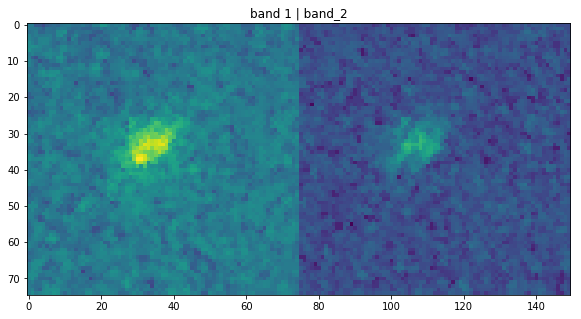

In [10]:
viz.plot_bands(example_iceberg)

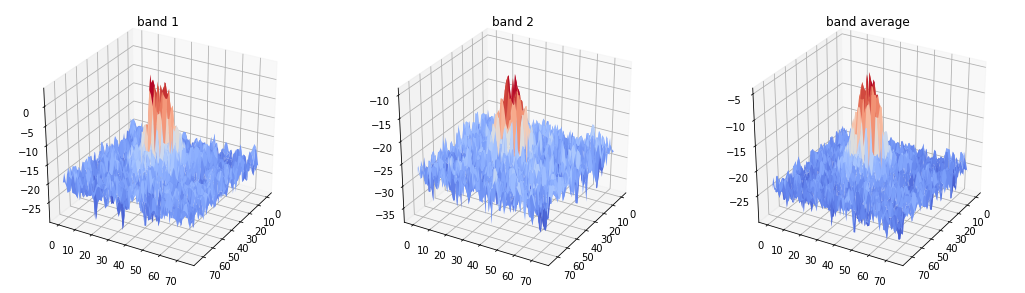

In [11]:
viz.plot_bands_3d(example_iceberg)

Some remarks:
- data seems to be centered
- this example is round, however checking further cases reveal that they vary a lot in size and shape
- the two bands can have a noticeable difference in intensity
- noise presence

---

Let's now look at an example of a ship.

In [12]:
example_ship = measures.iloc[0]
example_ship

band_1        [-27.878360999999998, -27.15416, -28.668615, -...
band_2        [-27.154118, -29.537888, -31.0306, -32.190483,...
inc_angle                                               43.9239
is_iceberg                                                    0
Name: dfd5f913, dtype: object

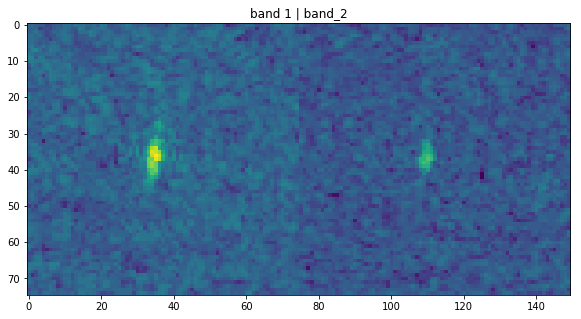

In [13]:
viz.plot_bands(example_ship)

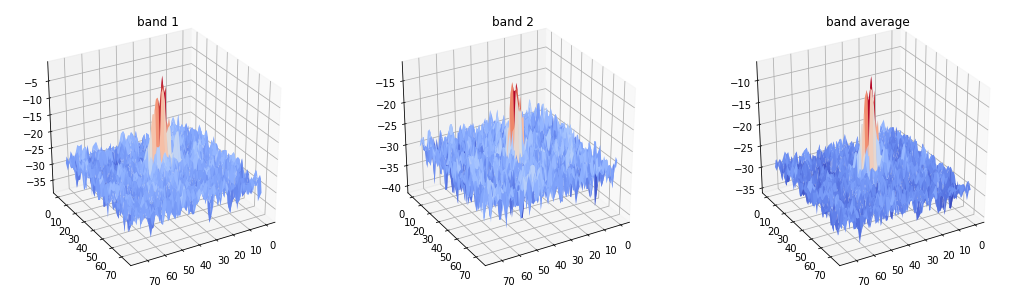

In [14]:
viz.plot_bands_3d(example_ship, angle=60)

Some remarks:

- data also seems to be centered
- this example has a ship-like shape, however checking further cases reveal that they also vary a lot
- noise does not seem to be different

---

What about the label distribution?

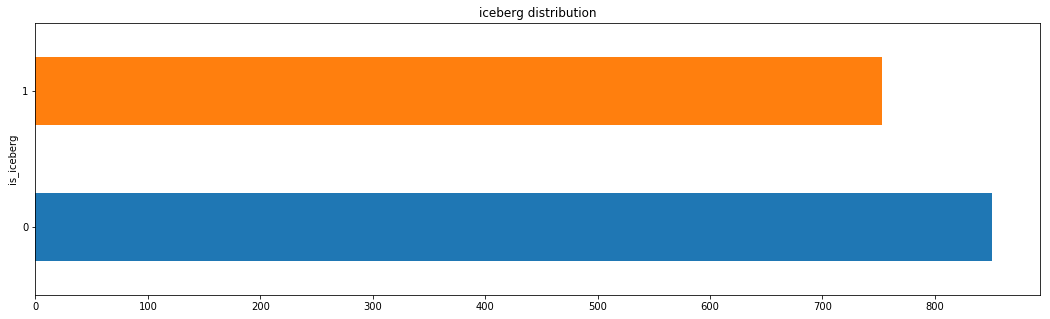

In [15]:
plt.title('iceberg distribution')
measures.groupby(measures.is_iceberg).is_iceberg.count().plot.barh();

The distribution of the two classes across the data is quite even (~53% of ships, ~47% of icebergs).

---

And what about distribution of features?

In [16]:
np.count_nonzero(measures.inc_angle.isnull())

133

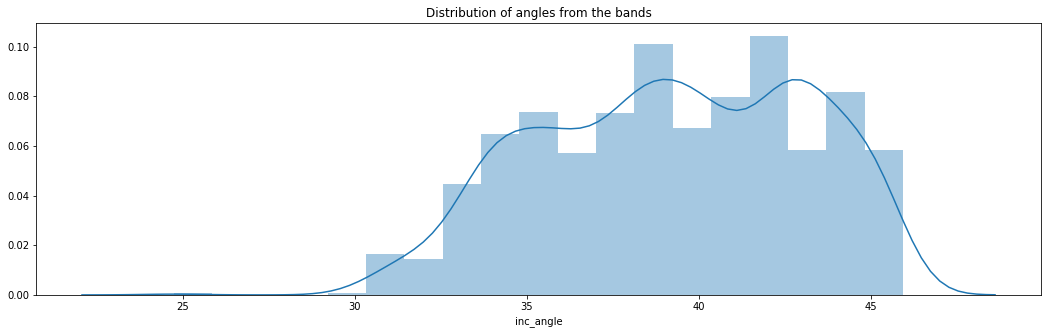

In [17]:
plt.title("Distribution of angles from the bands")
sns.distplot(measures.inc_angle.dropna());

133 of the measures have an absent angle, so we just ignore them for the correlation coefficient and they will be replaced later during the learning.

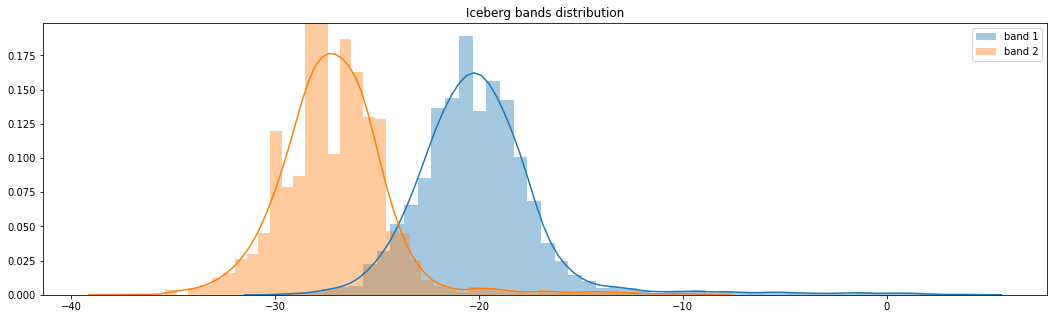

In [18]:
plt.title('Iceberg bands distribution')
sns.distplot(example_iceberg.band_1, label='band 1')
sns.distplot(example_iceberg.band_2, label='band 2')
plt.legend();

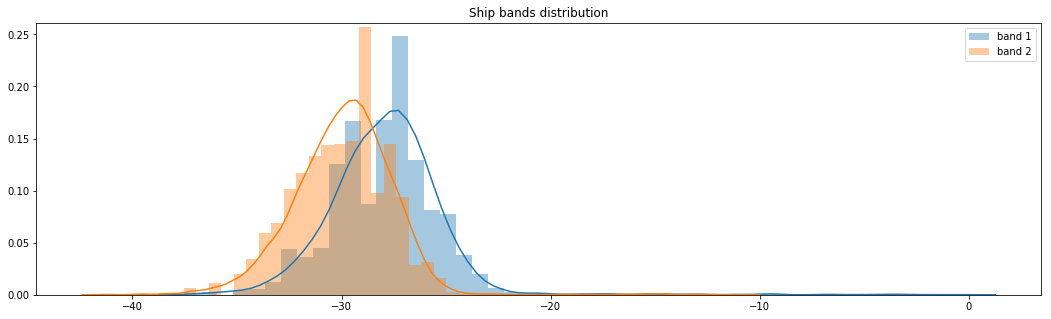

In [19]:
plt.title('Ship bands distribution')
sns.distplot(example_ship.band_1, label='band 1')
sns.distplot(example_ship.band_2, label='band 2')
plt.legend();

Bands appear as bell-shapes and their difference might contain valuable information. This is why the same scaler will be used later to perserve their eventual gaps.

---

T-SNE allows to represent non-linear high dimensionality data on only two dimensions which can be easily visualized.

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [21]:
# pca can speed up T-SNE and suppress some residual noise
pca50 = PCA(n_components=50).fit_transform(np.c_[np.stack(measures.band_1), np.stack(measures.band_2)])

In [22]:
tsne = TSNE(n_components=2, perplexity=60).fit_transform(pca50)

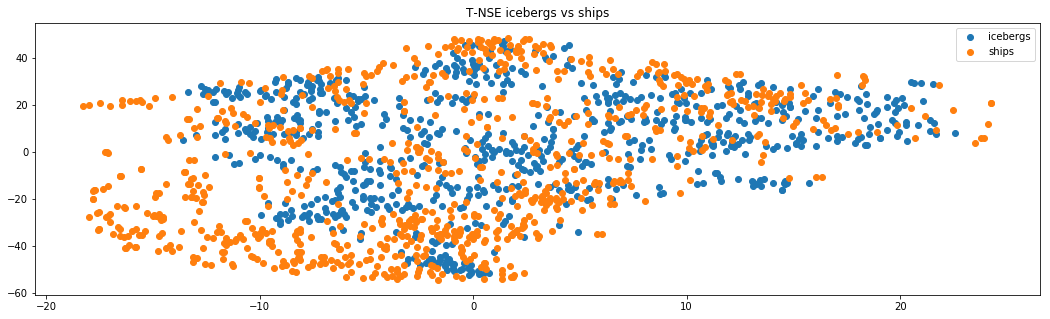

In [23]:
plt.title('T-NSE icebergs vs ships')
plt.scatter(tsne[measures.is_iceberg == 1, 0], tsne[measures.is_iceberg == 1, 1], label='icebergs')
plt.scatter(tsne[measures.is_iceberg == 0, 0], tsne[measures.is_iceberg == 0, 1], label='ships')
plt.legend();

The T-SNE does not show any obvious underlying clue (e.g. clusters) after some parameters tweaking. This problem is thus unlikely to be resolved by simple classifiers as such as k-nearest neighbors. It can be noticed that some regions are "closely" shared among icebergs and ships whereas other are more distinct.

### Prototypes

One interesting first point is to look whether there are some prototypes (distinct primitive shapes). This allows to gather insights that will be later useful if there is any imbalance between icebergs and ships. For example, one could try to cluster similar average band together:

In [24]:
from sklearn.cluster import KMeans

In [25]:
n_proto = 8
kmeans = KMeans(n_clusters=n_proto).fit(
    (np.stack(measures.band_1) + np.stack(measures.band_2)) / 2
)
kmeans_centers = kmeans.cluster_centers_

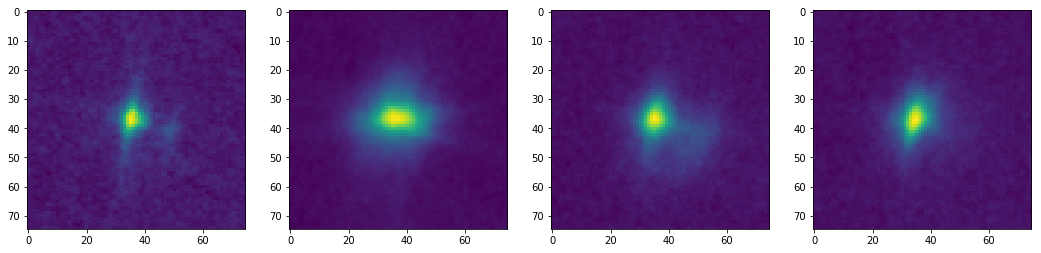

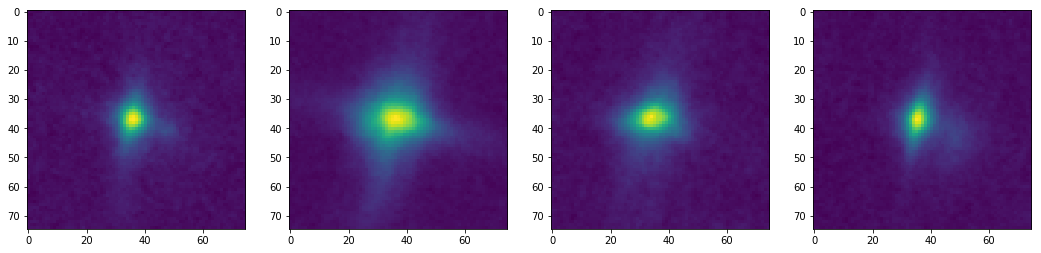

In [26]:
for i, center in enumerate(kmeans_centers):
    plt.subplot(1, 4, i % 4 + 1)
    plt.imshow(center.reshape(75, 75))
    if i % 4 == 3:
        plt.show()

In [27]:
# per cluster, per label, counts
measures.is_iceberg.groupby(kmeans.labels_).apply(pd.value_counts)

0  0     63
   1     16
1  0     99
   1     16
2  1    198
   0    110
3  0    154
   1    101
4  1    138
   0    105
5  0     62
   1     20
6  0    108
   1     37
7  1    227
   0    150
Name: is_iceberg, dtype: int64

Although the first two clusters seems to have a majority of ships, prototypes are unlikely to be specific to a given label in such high dimensions (partly because of curse of dimensionality). However this confirms the hypothesis on centered data and shows the prescence of some scatter reflections. Increasing the number of clusters looks to improve the classification between the two, however the quality does not improve. 

## 3 - Preprocessing

There is no particular pre-processing to do (except from scaling and managing the N/A), since the data is already nicely formatted. Also since the image are already quite small (75x75), in particular the central zone of interest, we choose not to smooth it (with a gaussian filter by example) in order not to loose important details. Noise might thus have a strong impact but this will also allow to see how graph based learning manage that issue.

### Train and test splits

Using the same `random_state`, the data is split the same way here as in the others notebooks where we tuned the models using cross-validation on the following train split. The test split is only used to compare final models.

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# random state is very important as they same split can be used in other notebooks
train, test = train_test_split(range(len(measures)), test_size=0.15, stratify=measures.is_iceberg, random_state=0)

Let's check that we did a fair (stratified) split for training and testing.

In [30]:
measures.iloc[train].is_iceberg.value_counts()

0    723
1    640
Name: is_iceberg, dtype: int64

In [31]:
measures.iloc[test].is_iceberg.value_counts()

0    128
1    113
Name: is_iceberg, dtype: int64

### Cleaning and scaling

The angle is likely to play an important role and will be replaced by `0` to stay distinct from known values. The bands will be scaled between 0 and 1 so that they preserve their respective mean (location).

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
band_scaler = MinMaxScaler()
angle_scaler = MinMaxScaler()

In [34]:
for _, e in measures.iloc[train].iterrows():
    band_scaler.partial_fit(e.band_1.reshape(1, -1))
    band_scaler.partial_fit(e.band_2.reshape(1, -1))
    
angle_scaler.fit(measures.iloc[train].inc_angle.dropna().values.reshape(-1, 1));

Usable data contains the two bands, the angle and the target (label).

In [35]:
bands = np.stack([
    band_scaler.transform(np.stack(measures.band_1)),
    band_scaler.transform(np.stack(measures.band_2)),
], axis=1).reshape(-1, 2, 75, 75)

In [36]:
angles = angle_scaler.transform(measures.inc_angle.fillna(0).values.reshape(-1, 1))

In [37]:
targets = measures.is_iceberg.values.reshape(-1, 1)

## 4 - Graphs

To prepare later graph-based learning, various grids and coarsening methods are showcased on small graphs. The motivation for using this dataset is to see how the two bands can be modelled as irregular domains versus classical convolution.

In [38]:
from gcnn import graph

#### Classical 2D grid

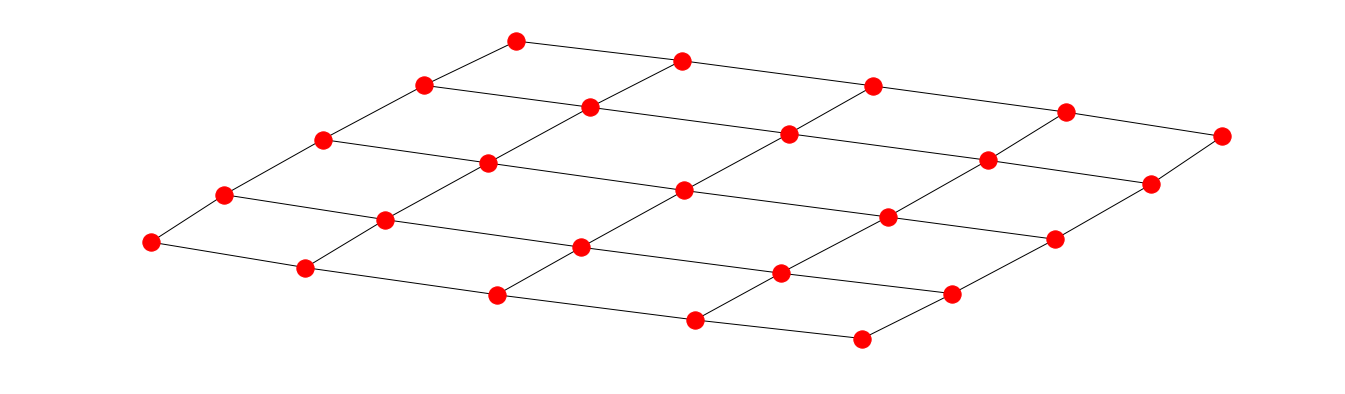

In [39]:
small_grid = nx.grid_graph([5, 5])
nx.draw(small_grid)

####  Knn 2D grid

Each node is connected to its k-nearest neighbors (or more in case of equality, this is due to the interpolation).

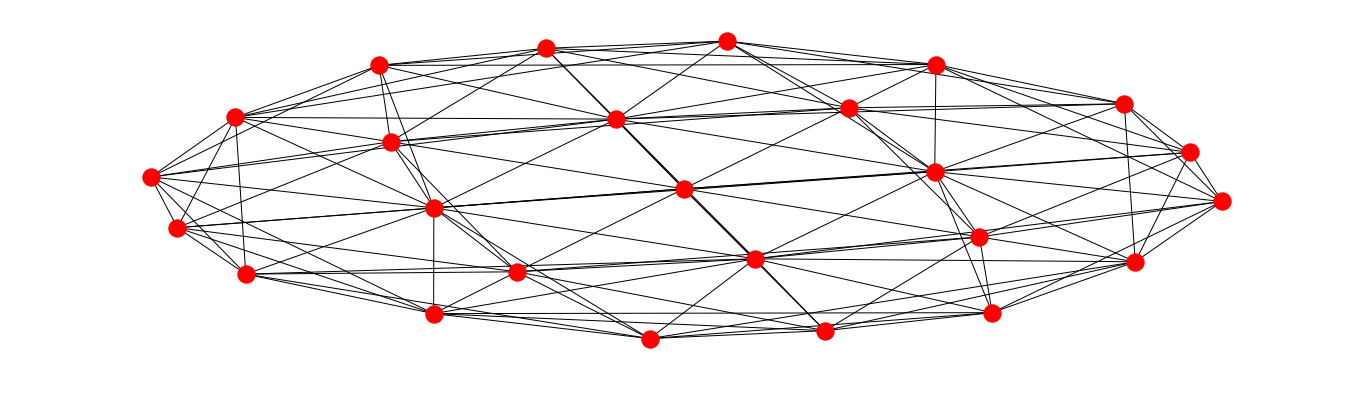

In [40]:
small_knn = graph.knn(graph.grid_coordinates(5), k=8, metric='cityblock')
nx.draw(small_knn)

#### Wrap-around Knn 2D grid

Same as above, with wrap-around borders.

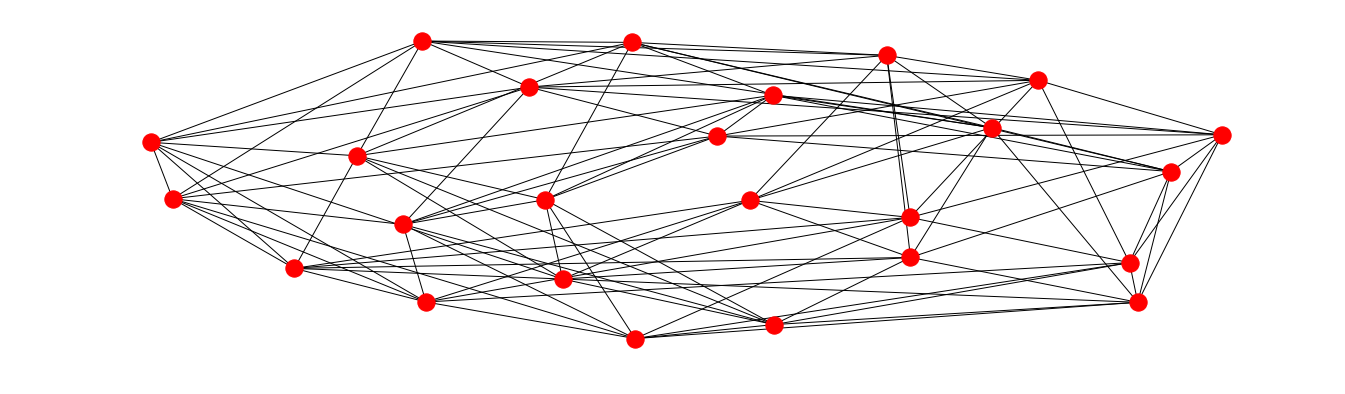

In [41]:
small_wraps = graph.kwraps(5, kd=1)
nx.draw(small_wraps)

#### Classical 3D grid

With two levels of depth.

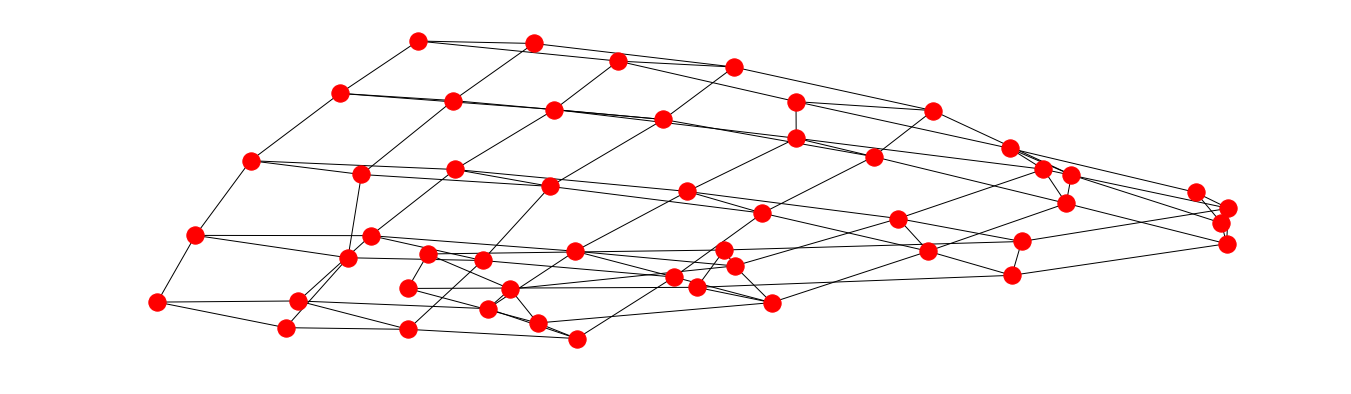

In [42]:
small_grid3d = nx.grid_graph([5, 5, 2])
nx.draw(small_grid3d)

#### Knn 3D grid

With two levels of depth.

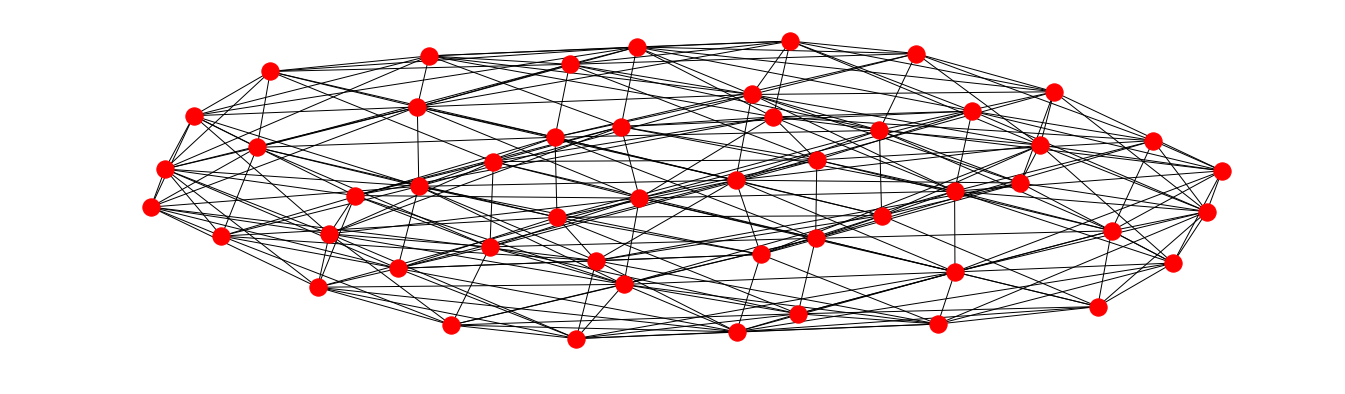

In [43]:
small_knn3d = graph.knn3d(graph.grid_coordinates(5), k=8, metric='cityblock', d=2)
nx.draw(small_knn3d)

#### 3D wrap-around grid

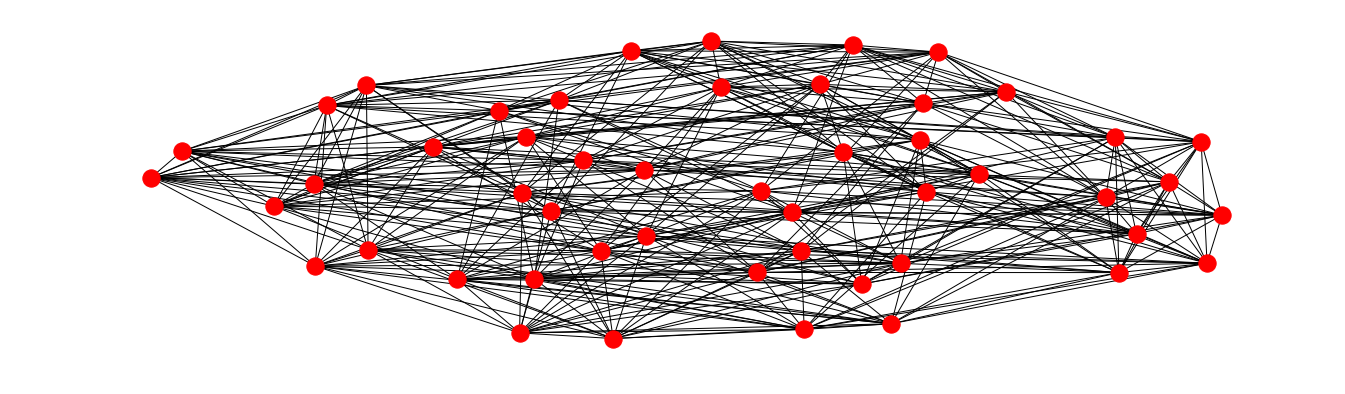

In [44]:
small_wraps3d = graph.kwraps3d(5, kd=1, d=2)
nx.draw(small_wraps3d)

Let's analyze how those graph compare in quantitative terms (e.g. connectivity).

In [45]:
small_graphs = [small_grid, small_knn, small_wraps, small_grid3d, small_knn3d, small_wraps3d]

In [46]:
[nx.average_node_connectivity(g) for g in small_graphs]

[2.82,
 8.373333333333333,
 8.0,
 3.8277551020408165,
 10.15265306122449,
 16.346938775510203]

- The first one (corresponding to the grid) should have an expected average around 4, as each node is connected to its four neighbors.
- The second one corresponds to a KNN with K = 8, we should have an average around 8 although as it is a small graph the high number of "corners" increases this average.
- The third one (wrapped grid) eliminates those border/corner cases and has the "true" average value. 
- The fourth one is similar to the 2D grid with one more dimension, therefore close to 4 as well.
- The fifth one, as the 2D KNN, has a lot of corner cases that increases average. 
- The sixth (3D wrappred grid) that has 9 neighbors in the 2D plane plus 8 from the nodes above or below.

In [47]:
print("Small grid : ", nx.average_clustering(small_grid))
print("Small KNN : ", nx.average_clustering(small_knn))
print("Small wraps : ", nx.average_clustering(small_wraps))
print("Small grid 3D : ", nx.average_clustering(small_grid3d))
print("Small KNN 3D : ", nx.average_clustering(small_knn3d))
print("Small wraps 3D : ", nx.average_clustering(small_wraps3d))

Small grid :  0.0
Small KNN :  0.6141183261183261
Small wraps :  0.42857142857142866
Small grid 3D :  0.0
Small KNN 3D :  0.47789543789543787
Small wraps 3D :  0.5294117647058829


When looking at the average clustering, one can underlying the two perfect grid cases when no asymmetry is present and thus no cluster. The other show an average clustering of ~0.5. However this does not tell much as the grid are small.

### Coarsening

The coarsening steps can be visualized step by step.

#### Graclus

[Graclus](http://www.cs.utexas.edu/users/dml/Software/graclus.html) is a fast graph clustering software that computes normalized or ratio cut. It might add some nodes to match a reduction by 2. Implementation is courtesy of Michael Defferrard.

In [48]:
from gcnn.coarsening import graclus

In [49]:
graclus_levels, _ = graclus.coarsen(nx.adjacency_matrix(small_grid), levels=2, self_connections=False)

Layer 0: M_0 = |V| = 28 nodes (3 added),|E| = 40 edges
Layer 1: M_1 = |V| = 14 nodes (1 added),|E| = 21 edges
Layer 2: M_2 = |V| = 7 nodes (0 added),|E| = 10 edges


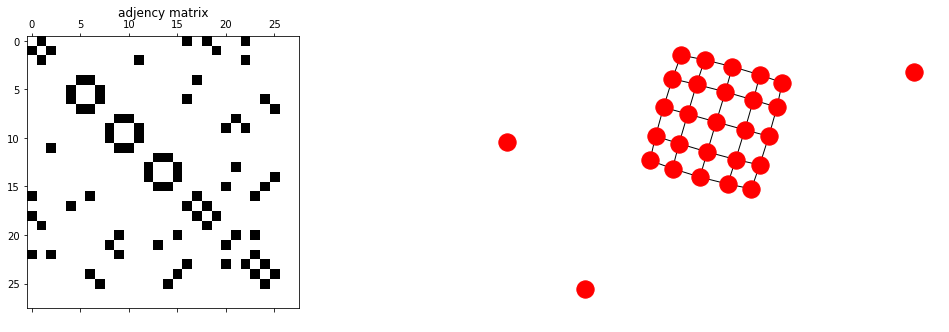

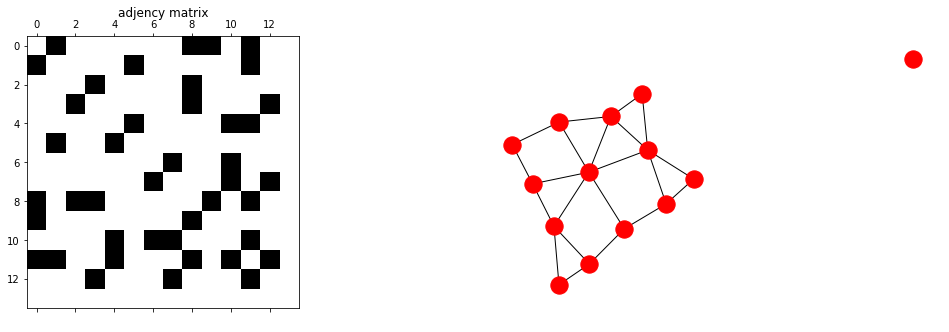

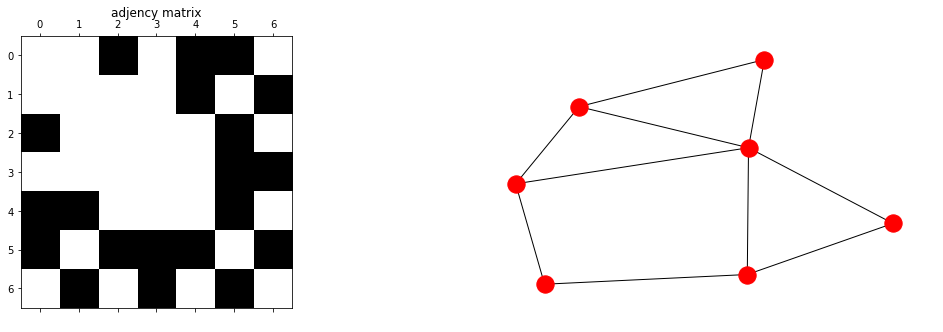

In [50]:
viz.plot_graph_steps(graclus_levels)

#### Algebraic multigrid

Algebraic multigrid for graph coarsening is a method projecting signals to a coarser graph representation obtained via greedy selections of vertices. The implementation uses `sklearn.clustering.SpectralClustering` which runs [PyAMG](https://github.com/pyamg/pyamg) underneath.

In [51]:
from gcnn.coarsening import amg

In [52]:
small_grid = nx.grid_graph([4, 4, 1])
small_dist = nx.adjacency_matrix(small_grid)
graphs, perm = amg.coarsen(small_dist, levels=3, self_connections=False)

Layer 0: M_0 = |V| = 16 nodes (0 added),|E| = 24 edges
Layer 1: M_1 = |V| = 8 nodes (0 added),|E| = 12 edges
Layer 2: M_2 = |V| = 4 nodes (0 added),|E| = 6 edges
Layer 3: M_3 = |V| = 2 nodes (0 added),|E| = 1 edges


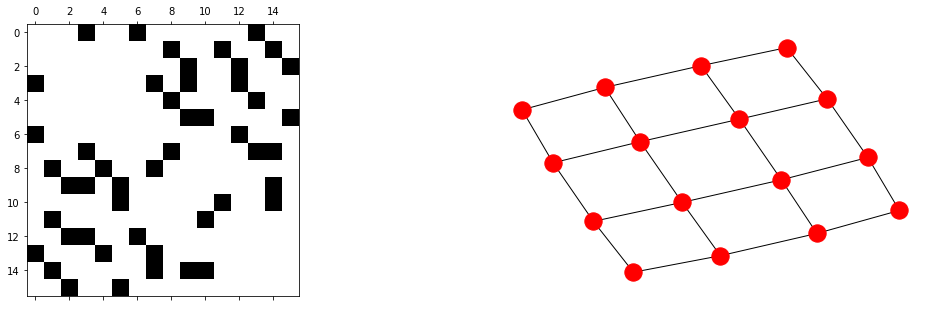

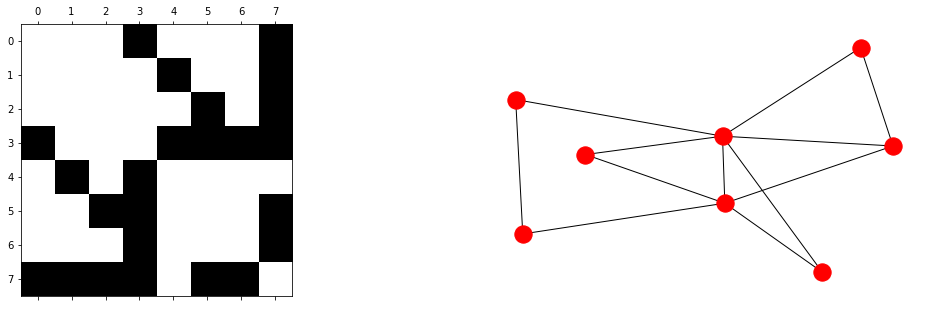

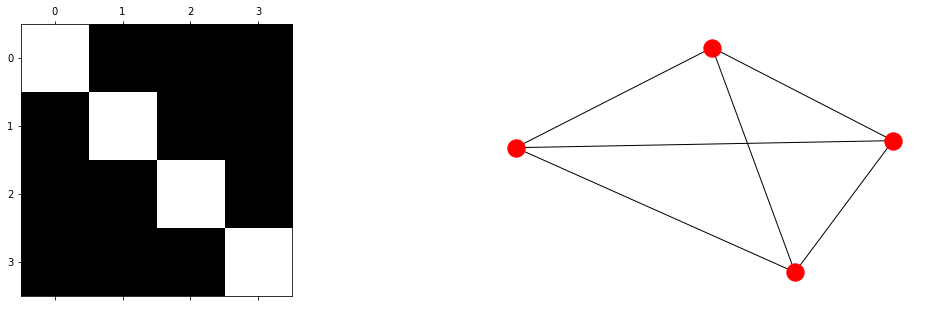

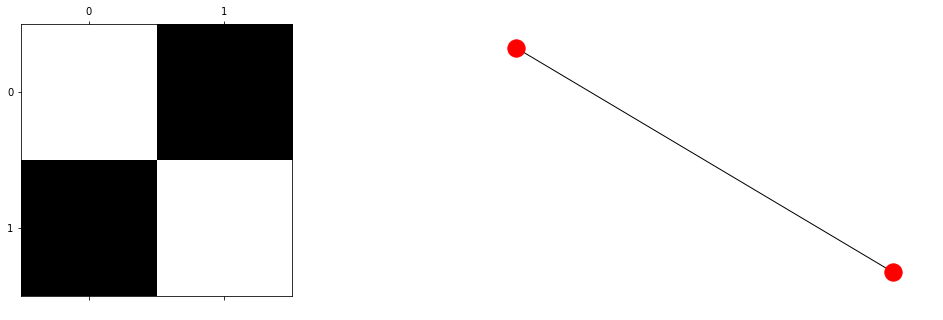

In [53]:
for g in graphs:
    plt.subplot(121)
    plt.spy(g.todense())
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g.todense()))
    plt.show()

#### Kron reduction
The Kron reduction of a graph is again a graph whose Laplacian matrix is obtained by the Schur complement of the original Laplacian matrix with respect to a subset of nodes. Implementation adapted from [PyGSP](http://pygsp.readthedocs.io/en/stable/).

In [54]:
from gcnn.coarsening import kron

In [55]:
kron_levels = kron.graph_multiresolution(sp.sparse.csr_matrix(nx.adjacency_matrix(small_grid)), levels=1)

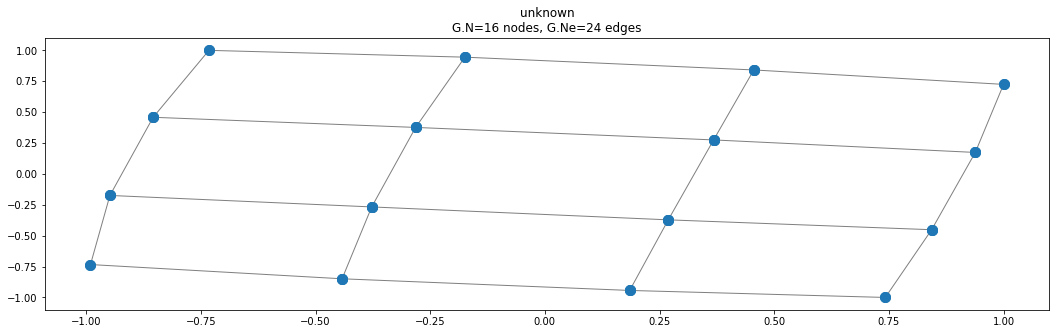

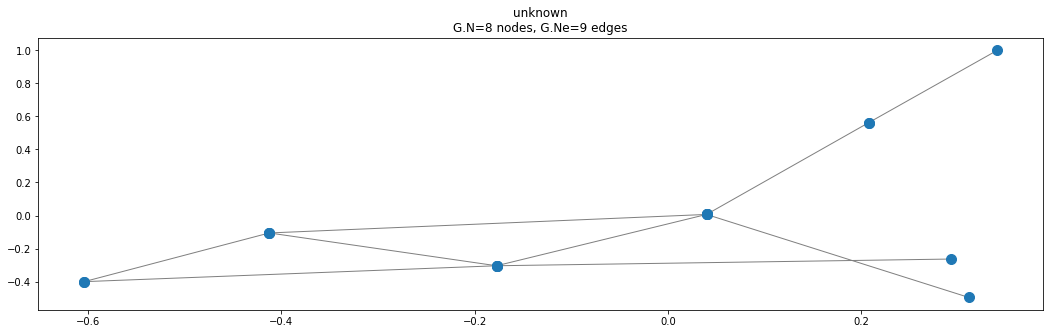

In [56]:
for g in kron_levels:
    g.set_coordinates()
    g.plot()

#### Maximum spanning tree

We tried to use a MST (Maximum Spaning Tree) based on downsampling. The idea is to find the max-cut to separate our nodes in a bipartite graph, but this problem is in general NP-hard. So to find a high-cut in a fast way, we took some inspiration of this paper (Nguyen, "Downsampling of Signals on Graphs Via Maximum Spanning Trees") and implemented our own solution.

The algorithm goes this way : find the MST of our connected (by construction) graph, using Prim's algorithm for example, then randomly choose one node to be the root node, and from there compute the distance of each node to the root node in the MST. From there, only keep the nodes which distance to the root is even. In the resulting graph, the weight between the nodes we kept are computed from the two edges that originally connected them in the MST.  

In [57]:
from gcnn.coarsening import mst

In [58]:
mst_levels = mst.mst(nx.adjacency_matrix(small_grid).todense(), levels=2)

/juypter/teo/Titanic/gcnn/coarsening/mst.py:48: RuntimeWarning: invalid value encountered in remainder
  even_nodes = distance_matrix[:, root] % 2 == 0


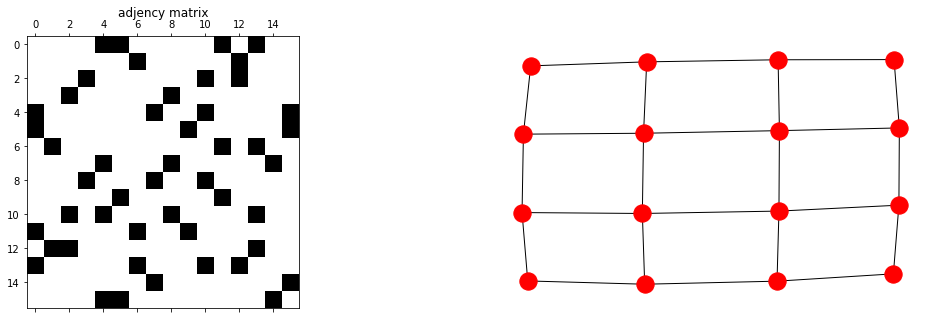

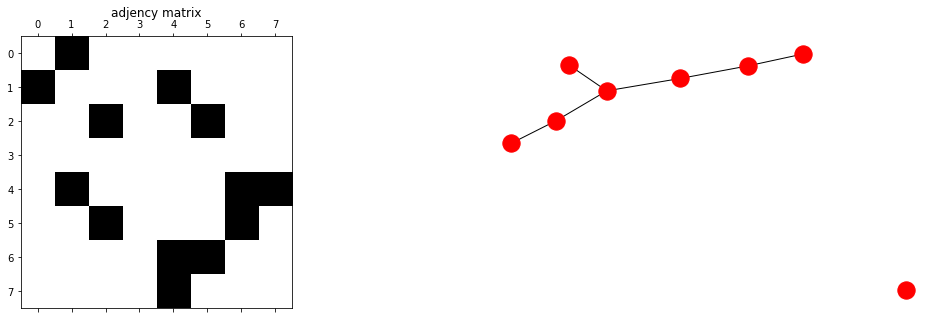

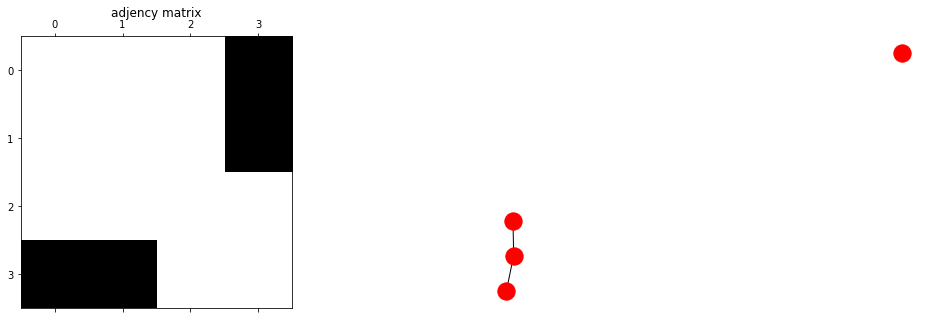

In [59]:
viz.plot_graph_steps(mst_levels)

However, we did not have the time to find an efficient way of knowing which nodes are being clustered together for the minimum spanning tree and kron based methods. This is left for future work.

## 5 - Models

Starting from standards models, classical convolution will be tuned and serve as a reference against graph convolutions. All parameters were tuned in other notebooks on same training set (cross-validated) and reported here.

In [60]:
scores = pd.DataFrame([], columns=['name', 'accuracy', 'precision', 'recall', 'f1']).set_index('name')
scores

,accuracy,precision,recall,f1
name,,,,


In [61]:
flat_features = np.c_[bands.reshape(-1, 2 * 75 * 75), angles.reshape(-1, 1)]
flat_features.shape

(1604, 11251)

### Standard methods

Let's start with a dummy classifier, then try the basic k-nearest neighbors and finally evaluate against a logistic regression which should outperform the first two.

In [62]:
from sklearn.dummy import DummyClassifier

In [63]:
dummy = DummyClassifier().fit(flat_features[train], targets[train].ravel())

In [64]:
from gcnn.utils import score_classification

In [65]:
scores.loc['baseline'] = score_classification(targets[test], dummy.predict(flat_features[test]))
scores

             precision    recall  f1-score   support

       ship       0.53      0.52      0.52       128
    iceberg       0.47      0.49      0.48       113

avg / total       0.50      0.50      0.50       241



,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261


In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [67]:
knn = KNeighborsClassifier(n_neighbors=6).fit(flat_features[train], targets[train].ravel())

In [68]:
scores.loc['knn'] = score_classification(targets[test], knn.predict(flat_features[test]))
scores

             precision    recall  f1-score   support

       ship       0.73      0.65      0.69       128
    iceberg       0.65      0.73      0.68       113

avg / total       0.69      0.68      0.68       241



,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261
knn,0.684647,0.645669,0.725664,0.683333


In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
logistic = LogisticRegression(C=0.1).fit(flat_features[train], targets[train].ravel())

In [71]:
scores.loc['logistic'] = score_classification(targets[test], logistic.predict(flat_features[test]))
scores

             precision    recall  f1-score   support

       ship       0.84      0.72      0.77       128
    iceberg       0.73      0.84      0.78       113

avg / total       0.78      0.78      0.78       241



,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261
knn,0.684647,0.645669,0.725664,0.683333
logistic,0.775934,0.725191,0.840708,0.778689


### Convolution baseline

Inspired from LeNet-5, the following architecture is used as a baseline for convolution. The training is performed by using Adam optimizer and no regularization is applied to the binary cross entropy loss.

|Layer|Output shape|Input connected to|
|-|-|-|
|Convolution2d|16|Convolution2d_input|
|MaxPool2d|4|Convolution2d|
|Convolution2d|32|MaxPool2d|
|MaxPool2d|4|Convolution2d|
|Linear|256|MaxPool2d|
|Linear|128|Linear|
|Linear|1||

In [72]:
cuda = torch.cuda.is_available()
cuda

True

In [73]:
import torch.utils.data as data_utils

Prepare pytorch tensors for later processing (cpu or gpu).

In [74]:
bands_t = torch.from_numpy(bands).float()
angles_t = torch.from_numpy(angles).float()
targets_t = torch.from_numpy(targets).float()

In [75]:
from gcnn.nets import BaselineCNN
from skorch import NeuralNet

Skorch provides a sklearn interface over pytorch models and will ease the training and evaluation.

In [76]:
cnn = NeuralNet(
    BaselineCNN,
    use_cuda=cuda,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss, 
    batch_size=50,
    max_epochs=20,
    lr=0.001,
)

In [77]:
from gcnn.utils import sigmoid

In [78]:
def score_fit_predict(name, model, bands, angles, targets):
    
    # fit model with bands and angles
    train_features = dict(x=bands[train], x2=angles[train])
    model.fit(train_features, targets[train])
    print()
    
    # need logit for prediction as it is included within optimizer
    test_features = dict(x=bands[test], x2=angles[test])
    preds = model.predict_proba(test_features)
    preds = sigmoid(preds).round()
    
    # save score
    scores.loc[name] = score_classification(targets[test], preds)
    return scores

In [79]:
score_fit_predict('conv', cnn, bands_t, angles_t, targets_t)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6827        0.6692  1.7592
      2        0.6557        0.6430  0.6717
      3        0.6040        0.5212  0.5924
      4        0.5237        0.4467  0.6099
      5        0.4599        0.3967  0.5756
      6        0.4159        0.3703  0.5857
      7        0.3870        0.3641  0.5808
      8        0.3326        0.4164  0.5726
      9        0.3269        0.3067  0.5724
     10        0.3009        0.2952  0.5739
     11        0.2742        0.2888  0.5730
     12        0.2247        0.2640  0.5746
     13        0.2097        0.2495  0.5683
     14        0.1865        0.2433  0.5717
     15        0.1633        0.2456  0.5769
     16        0.1453        0.2539  0.5719
     17        0.1306        0.2397  0.5711
     18        0.1220        0.2566  0.5754
     19        0.0944        0.3128  0.5744
     20        0.0964        0.2899  0.5728

             precision    recal

,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261
knn,0.684647,0.645669,0.725664,0.683333
logistic,0.775934,0.725191,0.840708,0.778689
conv,0.854772,0.848214,0.840708,0.844444


### Graph convolution (Graclus)

Graph convolution was first based on graph fourier transform. However with large data, the cost of performing a change of basis becomes prohibitive. The alternative is to use a Cheyshev polynomial to avoid these computating and estimate the filtering.

|Layer|Output shape|Input connected to|
|-|-|-|
|GraphFourierConv / GraphChebyshevConv|16|GraphFourierConv_input / GraphChebyshevConv_input|
|MaxPool2d|4|GraphFourierConv / GraphChebyshevConv|
|GraphFourierConv / GraphChebyshevConv|32|MaxPool2d|
|MaxPool2d|4|GraphFourierConv / GraphChebyshevConv|
|Linear|256|MaxPool2d|
|Linear|128|Linear|
|Linear|1||

In [80]:
import scipy.sparse
from scipy.sparse import csgraph
from gcnn.nets import GraphCNN

In [81]:
def coarsen_permute(graph, bands, algo=graclus):
    
    # node should be ordered in a way corresponding to bands data order
    if type(graph) != np.ndarray:
        grid = nx.adjacency_matrix(graph, sorted(graph.nodes))
    else:
        grid = graph
        
    # coarsen grid
    grid = sp.sparse.csr.csr_matrix(grid)
    laps, perms = algo.coarsen(grid, levels=3, self_connections=False)
    print()
    
    # compute normed laplacian
    laps = [csgraph.laplacian(g, normed=True) for g in laps[:-1]]
    
    # update data accordingly
    pbands = graclus.perm_data(bands, perms)
    pbands = torch.from_numpy(pbands).float()
    
    return laps, pbands

In [82]:
def gc_model(laps):
    l0 = torch.from_numpy(laps[0].todense()).float()
    l2 = torch.from_numpy(laps[2].todense()).float()
    
    if cuda:
        l0 = l0.cuda()
        l2 = l2.cuda()
    
    return NeuralNet(
        GraphCNN,
        module__k=25, # if k None then fourier mode and should send fourier basis instead of laplacian
        module__lf0=l0,
        module__lf2=l2,
        use_cuda=cuda,
        optimizer=torch.optim.Adam,
        criterion=nn.BCEWithLogitsLoss, 
        batch_size=50,
        max_epochs=20,
        lr=0.001,
    )

In [83]:
def gc_single_band(name, grid, size=75, algo=graclus):
    laps, pbands = coarsen_permute(grid, bands[:, 0, :, :].reshape(-1, size * size), algo)
    return score_fit_predict(name, gc_model(laps), pbands, angles_t, targets_t)

In [84]:
def gc_both_bands(name, grid, size=75, algo=graclus):
    laps, pbands = coarsen_permute(grid, bands.reshape(-1, 2 * size * size), algo)
    return score_fit_predict(name, gc_model(laps), pbands, angles_t, targets_t)

As each graph has a particular nodes ordering, precaution need to be taken. First using the 2D graph, the learning will only happen on the first band.

In [85]:
gc_single_band('gcnn_grid', nx.grid_graph([75, 75]))

Layer 0: M_0 = |V| = 6992 nodes (1367 added),|E| = 11100 edges
Layer 1: M_1 = |V| = 3496 nodes (464 added),|E| = 7541 edges
Layer 2: M_2 = |V| = 1748 nodes (114 added),|E| = 4372 edges
Layer 3: M_3 = |V| = 874 nodes (0 added),|E| = 2414 edges

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7044        0.6794  6.3170
      2        0.6708        0.6707  6.3196
      3        0.6601        0.6799  6.3358
      4        0.6650        0.6677  6.3178
      5        0.6507        0.6947  6.3218
      6        0.6534        0.6584  6.3319
      7        0.6445        0.6795  6.3404
      8        0.6511        0.6567  6.3258
      9        0.6429        0.6533  6.3230
     10        0.6310        0.6328  6.3258
     11        0.6105        0.6320  6.3272
     12        0.6034        0.6460  6.3304
     13        0.5959        0.6369  6.3223
     14        0.5733        0.5602  6.3327
     15        0.5330        0.5430  6.3304
     16 

,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261
knn,0.684647,0.645669,0.725664,0.683333
logistic,0.775934,0.725191,0.840708,0.778689
conv,0.854772,0.848214,0.840708,0.844444
gcnn_grid,0.788382,0.822917,0.699115,0.755981


In [86]:
# simple grid often performed badly as it might be not enough connected
# gc_single_band('gcnn_knn', graph.knn(graph.grid_coordinates(75), k=8, metric='cityblock'))

In [87]:
gc_single_band('gcnn_kwraps', graph.kwraps(75, kd=1))

Layer 0: M_0 = |V| = 6616 nodes (991 added),|E| = 22500 edges
Layer 1: M_1 = |V| = 3308 nodes (318 added),|E| = 12008 edges
Layer 2: M_2 = |V| = 1654 nodes (81 added),|E| = 5580 edges
Layer 3: M_3 = |V| = 827 nodes (0 added),|E| = 2699 edges

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6966        0.6791  5.8008
      2        0.6708        0.6684  5.7878
      3        0.6604        0.6620  5.7916
      4        0.6523        0.6580  5.7851
      5        0.6521        0.6526  5.7904
      6        0.6297        0.6790  5.7850
      7        0.6288        0.6340  5.7842
      8        0.6220        0.6100  5.7946
      9        0.6008        0.6049  5.7853
     10        0.5881        0.5755  5.7862
     11        0.5707        0.5519  5.7885
     12        0.5367        0.5213  5.7852
     13        0.5187        0.5152  5.7877
     14        0.4975        0.5014  5.7865
     15        0.4857        0.4872  5.7863
     16  

,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261
knn,0.684647,0.645669,0.725664,0.683333
logistic,0.775934,0.725191,0.840708,0.778689
conv,0.854772,0.848214,0.840708,0.844444
gcnn_grid,0.788382,0.822917,0.699115,0.755981
gcnn_kwraps,0.780083,0.705479,0.911504,0.795367


Now, let's take into account the two bands and use the 3D graphs. As some of the 3D graph have a large number of edges, some of them are randomly pruned to reduce required memory.

In [95]:
# simple grid often performed badly as it might be not enough connected
# gc_both_bands('gcnn_grid_3', nx.grid_graph([75, 75, 2]))

In [96]:
# skipped: too time-consuming
# gc_both_bands('gcnn_knn_3', graph.knn3d(graph.grid_coordinates(75), k=8, metric='cityblock', d=2))

In [97]:
from gcnn.graph import remove_random_edges

In [98]:
# skipped: too time-consuming
# gc_both_bands(
#     'gcnn_kwraps_3', 
#     remove_random_edges(
#         graph.kwraps3d(
#             75, 
#             kd=1, 
#             d=2
#         ),
#         50000
#     )
# )

## 6 - Evaluation

We have a comparison between a few cases.

In [99]:
scores

,accuracy,precision,recall,f1
name,,,,
baseline,0.502075,0.470085,0.486726,0.478261
knn,0.684647,0.645669,0.725664,0.683333
logistic,0.775934,0.725191,0.840708,0.778689
conv,0.854772,0.848214,0.840708,0.844444
gcnn_grid,0.788382,0.822917,0.699115,0.755981
gcnn_kwraps,0.780083,0.705479,0.911504,0.795367


In this table we have the different results for all the methods we tried. The baseline was just a random model, and we can see that every score is around 0.5. For the KNN, the score is quite high, especially the recall, which is desirable for our application (classifying some ships as icebergs is not so problematic, but we do not want to miss any iceberg).

While those neural network models are quite good accouting for the high noise and few data, the graph based models are better in some aspects. In particular, the precision score of `gcnn_grid` with only a single band is high, but it does have some lower recall. `gcnn_kwraps` achieve even a surprising recall. Overall, the standard convolutional model is the most balanced one with f1 score being the highest of all models. Thus, graph convolutional model provided interesting alternative to standard methods on some aspect. More tuning and more data would be required to draw some conclusion.

## 7 - Conclusion

To sum up, we first had a look on the dataset to inspect and explore possible analysis directions. We then preprocessed it for later usage. The next step was to review possible graphs models and their coarsening. On the four coarsening methods presented, we used only Graclus as it was the best tradeoff between complexity and usage (permutation are linear). AMG provide an interesting alternative but we could not afford its long running time in the final notebook. We finally compare standard machine learning models, convolutional neural networks and various graph convolutional neural network to see whether the latter bring novelty and new insights.

In the end, as training and hyperparameter tuning time take a lot of time, we decided to select `gcnn_grid` and `gcnn_kwraps` for the final comparison. The `gcnn_knn` was indeed already compared in previous work and the selected one show interesting points. The graph models show a high variance in the training with sudden jump. Regularizations helped a bit to stabilize, however we decided to go without in order not to introduce difference between learning schemes. Some challenges were moreover faced as we had access to only 1000 labels and more data would be required to performed a fine-tuned and perfectly fair comparison.

Thus, deep learning on irregular domains can help to save lifes but further research and work is required.

### Possible improvements

- try to use more sparse operations, especially in pytorch (even it not all are supported)
- for a better and more detailed comparisom, more parameters should be tried and the variance of the scoring reported
- a lots of speedup can be performed to improve both coarsening algorithms and training (e.g. lazy values)
- one interesting followup would be to implement graph deconvolution and inspect what the filter actually does

## 8 - References

- TORRES, Ramon, SNOEIJ, Paul, GEUDTNER, Dirk, et al. GMES Sentinel-1 mission. Remote Sensing of Environment, 2012, vol. 120, p. 9-24.
- SHUMAN, David I., NARANG, Sunil K., FROSSARD, Pascal, et al. The emerging field of signal processing on graphs: Extending high-dimensional data analysis to networks and other irregular domains. IEEE Signal Processing Magazine, 2013, vol. 30, no 3, p. 83-98.
- BRONSTEIN, Michael M., BRUNA, Joan, LECUN, Yann, et al. Geometric deep learning: going beyond euclidean data. IEEE Signal Processing Magazine, 2017, vol. 34, no 4, p. 18-42.
- DEFFERRARD, Michaël, BRESSON, Xavier, et VANDERGHEYNST, Pierre. Convolutional neural networks on graphs with fast localized spectral filtering. In : Advances in Neural Information Processing Systems. 2016. p. 3844-3852.
- NGUYEN Ha Q., DO Minh N, et al. Downsampling of Signal on Graphs Via Maximum Spanning Trees. IEEE Transactions on Signal Processing, 2015, vol. 63, no 1.
- DORFLER Florain, BULLO Francesco. Kron reduction of graphs with applications to electrical networks. 2011.